In [157]:
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr

### plotting 
from matplotlib import pyplot as plt
import seaborn as sns

In [109]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

In [110]:
import climpred 

In [111]:
import xskillscore

In [112]:
sys.path.append(str(HOME.joinpath('research/Smart_Ideas/code/ml4seas')))

In [113]:
import utils

### read the GCMs 

In [114]:
var_name = 'SST'

In [115]:
ecmwf_path = pathlib.Path(f"/media/nicolasf/END19101/data/GCMs/processed/CDS/ECMWF/{var_name}/")

In [116]:
lfiles = list(ecmwf_path.glob(f"CDS_ECMWF_{var_name}_????-??_monthly_anomalies_1981_2010_clim.nc"))

In [117]:
lfiles.sort()

In [118]:
len(lfiles)

468

In [119]:
lfiles[0]

PosixPath('/media/nicolasf/END19101/data/GCMs/processed/CDS/ECMWF/SST/CDS_ECMWF_SST_1981-01_monthly_anomalies_1981_2010_clim.nc')

In [120]:
lfiles[-1]

PosixPath('/media/nicolasf/END19101/data/GCMs/processed/CDS/ECMWF/SST/CDS_ECMWF_SST_2019-12_monthly_anomalies_1981_2010_clim.nc')

In [121]:
dset_ecmwf = xr.open_mfdataset(lfiles, concat_dim='init_time', combine='nested')

In [122]:
dset_ecmwf

,Array,Chunk
Bytes,18.30 GB,39.10 MB
Shape,"(468, 6, 25, 181, 360)","(1, 6, 25, 181, 360)"
Count,1872 Tasks,468 Chunks
Type,float32,numpy.ndarray


In [123]:
dset_ecmwf = dset_ecmwf.drop('month')

### Now read the observed SSTs 

In [124]:
ersst_path = pathlib.Path('/media/nicolasf/END19101/data/ERSST/processed/')

In [125]:
lfiles = list(ersst_path.glob("ERSST_monthly_anomalies_*.nc"))

In [126]:
lfiles.sort()

In [127]:
lfiles[0]

PosixPath('/media/nicolasf/END19101/data/ERSST/processed/ERSST_monthly_anomalies_1979-01.nc')

In [128]:
lfiles[-1]

PosixPath('/media/nicolasf/END19101/data/ERSST/processed/ERSST_monthly_anomalies_2020-03.nc')

In [129]:
dset_ersst = xr.open_mfdataset(lfiles, concat_dim='time', combine='nested')

### interpolate the ECMWF dataset onto the ERSST grid 

In [130]:
dset_ecmwf = dset_ecmwf.interp_like(dset_ersst[['lat','lon']])

### Now try climpred 

In [131]:
from climpred import HindcastEnsemble

### rename the variables 

In [132]:
dset_ecmwf = dset_ecmwf.rename({'init_time':'init','step':'lead'})

### add the units to the `lead` variable 

In [133]:
dset_ecmwf['lead'].attrs = {'units':'months'}

In [134]:
dset_ecmwf

,Array,Chunk
Bytes,4.50 GB,9.61 MB
Shape,"(468, 6, 25, 89, 180)","(1, 6, 25, 89, 180)"
Count,4216 Tasks,468 Chunks
Type,float32,numpy.ndarray


### try and initialise a hincast ensemble 

In [135]:
hindcast = climpred.HindcastEnsemble(dset_ecmwf)

In [136]:
hindcast

climpred.HindcastEnsemble

,Array,Chunk
Bytes,4.50 GB,9.61 MB
Shape,"(468, 6, 25, 89, 180)","(1, 6, 25, 89, 180)"
Count,4216 Tasks,468 Chunks
Type,float32,numpy.ndarray


### now fix the ERSST dataset 

In [137]:
# dset_ersst = dset_ersst.drop('month')

In [138]:
dset_ersst

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 495)
Coordinates:
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2020-03-31
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 5 6 7 8 9 10 11 12 1 2 3
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(1, 89, 180), meta=np.ndarray>

### shift the time 

In [139]:
ersst_index = dset_ersst['time'].to_index()

In [140]:
dset_ersst['time'] = ersst_index.shift(periods=-1, freq='MS')

In [141]:
dset_ersst

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 495)
Coordinates:
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-03-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 5 6 7 8 9 10 11 12 1 2 3
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(1, 89, 180), meta=np.ndarray>

In [142]:
hindcast = hindcast.add_observations(dset_ersst)

In [143]:
hindcast

climpred.HindcastEnsemble

,Array,Chunk
Bytes,4.50 GB,9.61 MB
Shape,"(468, 6, 25, 89, 180)","(1, 6, 25, 89, 180)"
Count,4216 Tasks,468 Chunks
Type,float32,numpy.ndarray


<Observations>
Dimensions: (lat: 89, lon: 180, time: 495)
Coordinates:
 * lat (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
 * lon (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
 * time (time) object 1979-01-01 00:00:00 ... 2020-03-01 00:00:00
 month (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 5 6 7 8 9 10 11 12 1 2 3
Data variables:
 sst (time, lat, lon) float32 dask.array<chunksize=(1, 89, 180), meta=np.ndarray> Observations Dimensions: lat : 89 lon : 180 time : 495 Coordinates: (4) lat (lat) float64 -88.0 -86.0 -84.0 ... 86.0 88.0 units : degrees_north long_name : Latitude standard_name : latitude axis : Y comment : Uniform grid from -88 to 88 by 2 array([-88., -86., -84., -82., -80., -78., -76., -74., -72., -70., -68., -66.,
 -64., -62., -60., -58., -56., -54., -52., -50., -48., -46., -44., -42.,
 -40., -38., -36., -34., -32., -30., -28., -26., -24., -22., -20., -18.,
 -16., -14., -12., -10., -8., -6., -4., -2., 0., 2., 4., 6.,
 8., 10., 12., 14., 16., 18., 20., 22., 24., 26., 28., 30.,
 32., 34., 36., 38., 40., 42., 44., 46., 48., 50., 52., 54.,
 56., 58., 60., 62., 64., 66., 68., 70., 72., 74., 76., 78.,
 80., 82., 84., 86., 88.]) lon (lon) float64 0.0 2.0 4.0 ... 354.0 356.0 358.0 units : degrees_east long_name : Longitude standard_name : longitude axis : X comment : Uniform grid from 0 to 358 by 2 array([ 0., 2., 4., 6., 8., 10., 12., 14., 16., 18., 20., 22.,
 24., 26., 28., 30., 32., 34., 36., 38., 40., 42., 44., 46.,
 48., 50., 52., 54., 56., 58., 60., 62., 64., 66., 68., 70.,
 72., 74., 76., 78., 80., 82., 84., 86., 88., 90., 92., 94.,
 96., 98., 100., 102., 104., 106., 108., 110., 112., 114., 116., 118.,
 120., 122., 124., 126., 128., 130., 132., 134., 136., 138., 140., 142.,
 144., 146., 148., 150., 152., 154., 156., 158., 160., 162., 164., 166.,
 168., 170., 172., 174., 176., 178., 180., 182., 184., 186., 188., 190.,
 192., 194., 196., 198., 200., 202., 204., 206., 208., 210., 212., 214.,
 216., 218., 220., 222., 224., 226., 228., 230., 232., 234., 236., 238.,
 240., 242., 244., 246., 248., 250., 252., 254., 256., 258., 260., 262.,
 264., 266., 268., 270., 272., 274., 276., 278., 280., 282., 284., 286.,
 288., 290., 292., 294., 296., 298., 300., 302., 304., 306., 308., 310.,
 312., 314., 316., 318., 320., 322., 324., 326., 328., 330., 332., 334.,
 336., 338., 340., 342., 344., 346., 348., 350., 352., 354., 356., 358.]) time (time) object 1979-01-01 00:00:00 ... 2020-03-... array([cftime.DatetimeProlepticGregorian(1979, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1979, 2, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1979, 3, 1, 0, 0, 0, 0), ...,
 cftime.DatetimeProlepticGregorian(2020, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(2020, 2, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(2020, 3, 1, 0, 0, 0, 0)], dtype=object) month (time) int64 1 2 3 4 5 6 7 ... 9 10 11 12 1 2 3 array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5,
 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3,
 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8,
 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1,
 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6,
 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4,
 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9,
 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2,
 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7,
 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5,
 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3,
 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8,
 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1,
 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6,
 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
 12, 1, 2, 3, 4

In [144]:
nino = utils.indices.calculate_NINO34(hindcast)

In [145]:
nino

climpred.HindcastEnsemble

<Initialized Ensemble>
Dimensions: (init: 468, lead: 6, member: 25)
Coordinates:
 * member (member) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
 * lead (lead) int64 0 1 2 3 4 5
 * init (init) object 1981-01-01 00:00:00 ... 2019-12-01 00:00:00
Data variables:
 sst (init, lead, member) float32 dask.array<chunksize=(1, 6, 25), meta=np.ndarray> Initialized Ensemble Dimensions: init : 468 lead : 6 member : 25 Coordinates: (3) member (member) int32 0 1 2 3 4 5 6 ... 19 20 21 22 23 24 long_name : ensemble_member array([ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
 18, 19, 20, 21, 22, 23, 24], dtype=int32) lead (lead) int64 0 1 2 3 4 5 units : months array([0, 1, 2, 3, 4, 5]) init (init) object 1981-01-01 00:00:00 ... 2019-12-... array([cftime.DatetimeProlepticGregorian(1981, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1981, 2, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1981, 3, 1, 0, 0, 0, 0), ...,
 cftime.DatetimeProlepticGregorian(2019, 10, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(2019, 11, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(2019, 12, 1, 0, 0, 0, 0)],
 dtype=object) Data variables: (1) sst (init, lead, member) float32 dask.array<chunksize=(1, 6, 25), meta=np.ndarray> 
 
 
 
 
 Array Chunk 
 
 
 Bytes 280.80 kB 600 B 
 Shape (468, 6, 25) (1, 6, 25) 
 Count 5620 Tasks 468 Chunks 
 Type float32 numpy.ndarray 
 
 
 
 
 

 <!-- Horizontal lines -->
 
 

 <!-- Vertical lines -->
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

 <!-- Colored Rectangle -->
 

 <!-- Horizontal lines -->
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

 <!-- Vertical lines -->
 
 

 <!-- Colored Rectangle -->
 

 <!-- Horizontal lines -->
 
 

 <!-- Vertical lines -->
 
 

 <!-- Colored Rectangle -->
 

 <!-- Text -->
 25 
 6 
 468 
 
 
 
 Attributes: (0)

<Observations>
Dimensions: (time: 495)
Coordinates:
 * time (time) object 1979-01-01 00:00:00 ... 2020-03-01 00:00:00
 month (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 5 6 7 8 9 10 11 12 1 2 3
Data variables:
 sst (time) float32 dask.array<chunksize=(1,), meta=np.ndarray> Observations Dimensions: time : 495 Coordinates: (2) time (time) object 1979-01-01 00:00:00 ... 2020-03-... array([cftime.DatetimeProlepticGregorian(1979, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1979, 2, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1979, 3, 1, 0, 0, 0, 0), ...,
 cftime.DatetimeProlepticGregorian(2020, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(2020, 2, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(2020, 3, 1, 0, 0, 0, 0)], dtype=object) month (time) int64 1 2 3 4 5 6 7 ... 9 10 11 12 1 2 3 array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5,
 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3,
 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8,
 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1,
 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6,
 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4,
 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9,
 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2,
 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7,
 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5,
 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3,
 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8,
 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1,
 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6,
 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4,
 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9,
 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2,
 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7,
 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5,
 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3,
 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8,
 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1,
 2, 3]) Data variables: (1) sst (time) float32 dask.array<chunksize=(1,), meta=np.ndarray> 
 
 
 
 
 Array Chunk 
 
 
 Bytes 1.98 kB 4 B 
 Shape (495,) (1,) 
 Count 3465 Tasks 495 Chunks 
 Type float32 numpy.ndarray 
 
 
 
 
 

 <!-- Horizontal lines -->
 
 

 <!-- Vertical lines -->
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

 <!-- Colored Rectangle -->
 

 <!-- Text -->
 495 
 1 
 
 
 
 Attributes: (0)

In [146]:
nino.load()

climpred.HindcastEnsemble

<Initialized Ensemble>
Dimensions: (init: 468, lead: 6, member: 25)
Coordinates:
 * member (member) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
 * lead (lead) int64 0 1 2 3 4 5
 * init (init) object 1981-01-01 00:00:00 ... 2019-12-01 00:00:00
Data variables:
 sst (init, lead, member) float32 -0.29116705 -0.37363774 ... 0.9190641 Initialized Ensemble Dimensions: init : 468 lead : 6 member : 25 Coordinates: (3) member (member) int32 0 1 2 3 4 5 6 ... 19 20 21 22 23 24 long_name : ensemble_member array([ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
 18, 19, 20, 21, 22, 23, 24], dtype=int32) lead (lead) int64 0 1 2 3 4 5 units : months array([0, 1, 2, 3, 4, 5]) init (init) object 1981-01-01 00:00:00 ... 2019-12-... array([cftime.DatetimeProlepticGregorian(1981, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1981, 2, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1981, 3, 1, 0, 0, 0, 0), ...,
 cftime.DatetimeProlepticGregorian(2019, 10, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(2019, 11, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(2019, 12, 1, 0, 0, 0, 0)],
 dtype=object) Data variables: (1) sst (init, lead, member) float32 -0.29116705 ... 0.9190641 array([[[-0.29116705, -0.37363774, -0.19078533, ..., -0.19614822,
 -0.30483913, -0.3483753 ],
 [-0.16801617, -0.25085074, -0.49890465, ..., -0.6605931 ,
 -0.36279932, -0.5227368 ],
 [ 0.29946384, 0.03796973, 0.08488253, ..., -0.57214683,
 -0.222129 , -0.37654302],
 [ 0.3071355 , 0.21689664, 0.13047086, ..., -0.8233685 ,
 -0.15708736, -0.25801182],
 [ 0.299673 , 0.20430908, -0.05082984, ..., -0.5270106 ,
 -0.20939918, 0.07532865],
 [ 0.23728286, 0.17525376, 0.17200458, ..., -0.41979817,
 -0.04166964, 0.10743267]],

 [[-0.8075043 , -0.6977631 , -0.6957792 , ..., -0.7499185 ,
 -0.72771794, -0.73474145],
 [-0.66599613, -0.20129159, -0.38946673, ..., -0.51798564,
 -0.5114384 , -0.43162677],
 [-0.4968257 , -0.14532588, -0.15807003, ..., -0.39482963,
 -0.35171813, -0.33175707],
 [-0.5128761 , 0.06159175, 0.08443392, ..., 0.0749176 ,
...
 0.32543266, 0.28020418],
 [ 0.46968925, 0.35306114, 0.11351013, ..., -0.06495573,
 0.0202139 , 0.24190016],
 [ 0.31305966, 0.2765104 , 0.30222332, ..., -0.05549129,
 -0.07184894, 0.39316288],
 [-0.0173854 , 0.14651889, -0.15369052, ..., 0.22790292,
 0.00687256, 0.54939854]],

 [[ 0.4224114 , 0.43174508, 0.4571923 , ..., 0.47713083,
 0.46934345, 0.5876179 ],
 [ 0.4393895 , 0.5516679 , 0.28333294, ..., 0.3246852 ,
 0.3995678 , 0.63190305],
 [ 0.58081335, 0.4125601 , -0.02113976, ..., -0.02275485,
 0.334483 , 0.2991631 ],
 [ 0.48638213, 0.3191843 , -0.04950209, ..., 0.00795218,
 0.60707515, 0.28216225],
 [ 0.46002573, 0.59779286, -0.4170835 , ..., -0.05180359,
 0.5215041 , 0.6605943 ],
 [ 0.34845558, 0.778264 , -0.15749489, ..., 0.01675791,
 0.5751742 , 0.9190641 ]]], dtype=float32) Attributes: (0)

<Observations>
Dimensions: (time: 495)
Coordinates:
 * time (time) object 1979-01-01 00:00:00 ... 2020-03-01 00:00:00
 month (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 5 6 7 8 9 10 11 12 1 2 3
Data variables:
 sst (time) float32 -0.14117885 -0.208941 ... 0.3689261 0.46420863 Observations Dimensions: time : 495 Coordinates: (2) time (time) object 1979-01-01 00:00:00 ... 2020-03-... array([cftime.DatetimeProlepticGregorian(1979, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1979, 2, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1979, 3, 1, 0, 0, 0, 0), ...,
 cftime.DatetimeProlepticGregorian(2020, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(2020, 2, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(2020, 3, 1, 0, 0, 0, 0)], dtype=object) month (time) int64 1 2 3 4 5 6 7 ... 9 10 11 12 1 2 3 array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5,
 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3,
 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8,
 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1,
 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6,
 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4,
 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9,
 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2,
 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7,
 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5,
 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3,
 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8,
 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1,
 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6,
 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4,
 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9,
 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2,
 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7,
 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5,
 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3,
 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8,
 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1,
 2, 3]) Data variables: (1) sst (time) float32 -0.14117885 ... 0.46420863 array([-1.41178846e-01, -2.08940998e-01, 3.10505647e-02, 1.24286860e-01,
 -1.20385818e-01, -1.58832744e-01, -3.52206081e-01, -8.14974532e-02,
 2.64880329e-01, 1.57914236e-01, 3.64139438e-01, 5.50080001e-01,
 5.29899240e-01, 2.27635533e-01, 7.15196058e-02, 4.26865369e-02,
 2.01823652e-01, 3.46466899e-01, 5.35302237e-02, -3.55398089e-01,
 -2.84815162e-01, -2.11851969e-01, -2.59122252e-02, 8.21392611e-02,
 -3.69449794e-01, -6.28574431e-01, -5.85312009e-01, -4.19604599e-01,
 -4.52243030e-01, -3.26718271e-01, -5.26344299e-01, -5.12225926e-01,
 -2.04461306e-01, -2.56149173e-01, -3.35042745e-01, -1.61611155e-01,
 1.20341152e-01, -1.52874619e-01, 1.78523123e-01, 3.17698896e-01,
 5.72274148e-01, 6.63841605e-01, 4.80776608e-01, 7.43103325e-01,
 1.47892487e+00, 2.02031898e+00, 1.98584926e+00, 2.22569060e+00,
 2.32530761e+00, 1.93579388e+00, 1.42042756e+00, 1.05752420e+00,
 1.02555442e+00, 6.84580624e-01, 1.30196940e-02, -2.35585809e-01,
 -5.21838486e-01, -1.10220146e+00, -1.20796418e+00, -9.88325953e-01,
 -6.79234445e-01, -1.82707056e-01, -4.68235761e-01, -5.71012020e-01,
 -6.14816546e-01, -7.67203331e-01, -3.95401508e-01, -2.29347974e-01,
 -3.49869102e-01, -6.34232998e-01, -1.10894275e+00, -1.30355382e+00,
 -1.16530645e+00, -7.15506434e-01, -7.40994155e-01, -1.06356859e+00,
 -9.05392587e-01, -7.80613124e-01, -6.27596319e-01, -5.39239407e-01,
...
 -1.99645355e-01, -1.67639211e-01, -7.91128278e-02, -1.52492166e-01,
 -5.12295067e-01, -6.23686433e-01, -2.4

In [147]:
acc = nino.verify(metric='pearson_r', comparison='e2o', dim='init', alignment='maximize', reference='persistence')

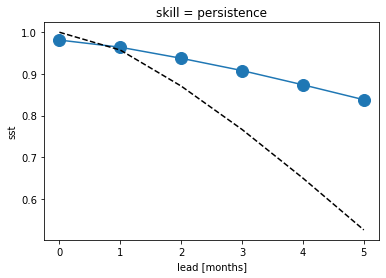

In [148]:
acc.sel(skill='initialized').sst.plot(marker='o', markersize=12)
acc.sel(skill='persistence').sst.plot(color='k', linestyle='--')

### skill as a function of initialisation month and leadtime 

In [149]:
result = []
for label, group in nino_ecmwf.groupby('init.month'):
    hindcast = HindcastEnsemble(group)
    hindcast = hindcast.add_observations(nino_ersst)
    hindcast.load()
    skill = hindcast.verify(metric='acc', comparison='e2o', dim='init', alignment='maximize')
    result.append(skill)

result = xr.concat(result, dim='month')
result['month'] = np.arange(12) + 1

In [185]:
result = result.to_dataframe()['sst'].unstack()

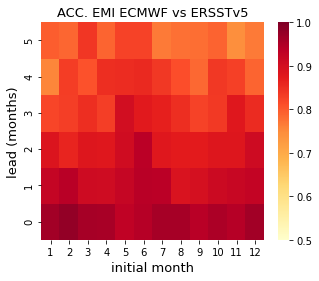

In [187]:
ax = sns.heatmap(result, cmap='YlOrRd', vmin=0.5, vmax=1) 
ax.invert_yaxis()
ax.set_xlabel('initial month', fontsize=13)
ax.set_ylabel('lead (months)', fontsize=13)
ax.set_title("ACC. NINO3.4 ECMWF vs ERSSTv5", fontsize=13)
f = plt.gcf() 
f.set_figheight(4)
f.set_figwidth(5)
f.savefig('./ACC_ECMWF_SST_NINO34.png', dpi=200, bbox_inches='tight')

### El Nino Modoki index 

In [179]:
EMI_ecmwf = utils.indices.calculate_EMI(dset_ecmwf)

In [180]:
EMI_ersst = utils.indices.calculate_EMI(dset_ersst)

In [181]:
hindcast_EMI = HindcastEnsemble(EMI_ecmwf)

In [182]:
hindcast_EMI = hindcast_EMI.add_observations(EMI_ersst)

In [183]:
hindcast_EMI.load()

climpred.HindcastEnsemble

<Initialized Ensemble>
Dimensions: (init: 468, lead: 6, member: 25)
Coordinates:
 * member (member) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
 * lead (lead) int64 0 1 2 3 4 5
 * init (init) object 1981-01-01 00:00:00 ... 2019-12-01 00:00:00
Data variables:
 sst (init, lead, member) float32 0.13116568 0.13809189 ... 0.23708588 Initialized Ensemble Dimensions: init : 468 lead : 6 member : 25 Coordinates: (3) member (member) int32 0 1 2 3 4 5 6 ... 19 20 21 22 23 24 long_name : ensemble_member array([ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
 18, 19, 20, 21, 22, 23, 24], dtype=int32) lead (lead) int64 0 1 2 3 4 5 units : months array([0, 1, 2, 3, 4, 5]) init (init) object 1981-01-01 00:00:00 ... 2019-12-... array([cftime.DatetimeProlepticGregorian(1981, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1981, 2, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1981, 3, 1, 0, 0, 0, 0), ...,
 cftime.DatetimeProlepticGregorian(2019, 10, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(2019, 11, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(2019, 12, 1, 0, 0, 0, 0)],
 dtype=object) Data variables: (1) sst (init, lead, member) float32 0.13116568 ... 0.23708588 array([[[ 0.13116568, 0.13809189, 0.25517178, ..., 0.2681998 ,
 0.1828829 , 0.14135385],
 [ 0.03464187, 0.18468344, 0.408023 , ..., 0.4369847 ,
 -0.17035386, -0.00815582],
 [-0.0210906 , 0.37411723, 0.2402393 , ..., 0.36115098,
 -0.15538192, 0.24087782],
 [ 0.10111107, 0.2657764 , 0.17608133, ..., -0.10097148,
 -0.13992384, 0.26888144],
 [-0.0027273 , -0.18455806, 0.11257154, ..., 0.20659198,
 0.02210645, 0.27323675],
 [-0.2461119 , -0.29875553, 0.11752226, ..., -0.0111229 ,
 0.06403597, 0.11622249]],

 [[ 0.20517778, 0.12417195, 0.25538585, ..., 0.32173496,
 0.22036085, 0.20330647],
 [ 0.41268125, -0.2625374 , 0.20649672, ..., 0.09493768,
 0.37374932, -0.09581961],
 [ 0.4331675 , -0.32100695, 0.43829155, ..., -0.07311919,
 0.2780235 , 0.0038469 ],
 [ 0.36676133, -0.01217064, 0.28049958, ..., -0.2822201 ,
...
 0.21894497, 0.07279693],
 [ 0.11369571, 0.07286581, -0.27505755, ..., -0.04070802,
 0.21864901, 0.09620732],
 [ 0.13508359, -0.00426283, 0.17433116, ..., -0.19636601,
 0.4234268 , 0.21462296],
 [ 0.40437636, 0.02109948, 0.12461559, ..., 0.07067639,
 0.6846773 , 0.2811875 ]],

 [[ 0.29562536, 0.30311298, 0.39918613, ..., 0.3659141 ,
 0.41809958, 0.1892116 ],
 [ 0.0042924 , 0.5500724 , 0.3977612 , ..., 0.4052891 ,
 0.2027218 , 0.20953509],
 [-0.27291322, 0.12291464, 0.27543807, ..., -0.09033155,
 0.07815434, -0.04711026],
 [-0.1225528 , 0.11636394, 0.00950442, ..., 0.01034747,
 0.20001128, -0.19812658],
 [ 0.04007703, 0.14115694, 0.18866129, ..., 0.49103254,
 0.31341708, -0.05553141],
 [ 0.06665719, 0.44294173, 0.18318683, ..., 0.2795422 ,
 0.2679448 , 0.23708588]]], dtype=float32) Attributes: (0)

<Observations>
Dimensions: (time: 495)
Coordinates:
 * time (time) object 1979-01-01 00:00:00 ... 2020-03-01 00:00:00
 month (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 5 6 7 8 9 10 11 12 1 2 3
Data variables:
 sst (time) float32 0.021600045 -0.024335578 ... 0.36218148 0.45876423 Observations Dimensions: time : 495 Coordinates: (2) time (time) object 1979-01-01 00:00:00 ... 2020-03-... array([cftime.DatetimeProlepticGregorian(1979, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1979, 2, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1979, 3, 1, 0, 0, 0, 0), ...,
 cftime.DatetimeProlepticGregorian(2020, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(2020, 2, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(2020, 3, 1, 0, 0, 0, 0)], dtype=object) month (time) int64 1 2 3 4 5 6 7 ... 9 10 11 12 1 2 3 array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5,
 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3,
 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8,
 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1,
 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6,
 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4,
 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9,
 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2,
 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7,
 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5,
 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3,
 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8,
 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1,
 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6,
 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4,
 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9,
 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2,
 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7,
 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5,
 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3,
 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8,
 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1,
 2, 3]) Data variables: (1) sst (time) float32 0.021600045 ... 0.45876423 array([ 0.02160005, -0.02433558, 0.21240056, 0.20220979, -0.01170522,
 -0.03023859, 0.07036872, -0.12897229, -0.2198004 , -0.03174561,
 0.22162037, 0.36731887, 0.48355347, 0.6059996 , 0.44513053,
 0.4748305 , 0.4280796 , 0.38048837, 0.4376622 , -0.0059804 ,
 0.0130893 , 0.29859373, 0.16097572, 0.06381457, 0.43262574,
 0.2821201 , 0.10772264, -0.1361389 , -0.2850439 , -0.289393 ,
 -0.43845564, -0.18925135, -0.01732942, -0.14235479, -0.10027353,
 0.01833398, 0.05197324, 0.04632782, 0.43741107, 0.6969985 ,
 0.61825967, 0.606925 , 0.34943062, 0.219856 , 0.05054072,
 0.2866889 , -0.13357893, -0.4587344 , -0.50877327, -0.26604468,
 -0.42931443, -0.82131284, -0.89540017, -1.2675443 , -1.2904196 ,
 -1.2149631 , -1.1537695 , -1.0031765 , -0.79395974, -0.50657576,
 -0.48047498, -0.2201972 , -0.3724352 , -0.4025704 , -0.12231497,
 0.0568855 , 0.02756968, -0.17415655, -0.26311392, -0.24602705,
 -0.4812909 , -0.35057026, -0.09531994, -0.07810029, -0.48359683,
 -0.35804126, -0.11373608, -0.07877914, 0.25410956, 0.2922328 ,
 0.22721772, 0.25442567, 0.12467858, 0.06523985, 0.03841125,
 -0.02500875, 0.22385508, 0.16321522, 0.14984776, 0.34521458,
 0.25192413, 0.27872467, 0.3909522 , 0.29607219, 0.41573104,
 0.30410647, 0.20075467, 0.43053108, 0.20598716, -0.10102986,
...
 -0.7053885 , -0.54629713, -0.39313316, 0.01581986, 0.08658583,
 0.4192797 , 0.44155213, 0.27238047, 0.06534564, -0.18639858,
 -0.29080594, -0.04306453, 0.16418308, 0.31275797, 0.22082596

In [184]:
result = []
for label, group in EMI_ecmwf.groupby('init.month'):
    hindcast = HindcastEnsemble(group)
    hindcast = hindcast.add_observations(EMI_ersst)
    hindcast.load()
    skill = hindcast.verify(metric='acc', comparison='e2o', dim='init', alignment='maximize')
    result.append(skill)

result = xr.concat(result, dim='month')
result['month'] = np.arange(12) + 1

In [ ]:
result = result.to_dataframe()['sst'].unstack()

In [ ]:
ax = sns.heatmap(result, cmap='YlOrRd', vmin=0.5, vmax=1) 
ax.invert_yaxis()
ax.set_xlabel('initial month', fontsize=13)
ax.set_ylabel('lead (months)', fontsize=13)
ax.set_title("ACC. EMI ECMWF vs ERSSTv5", fontsize=13)
f = plt.gcf() 
f.set_figheight(4)
f.set_figwidth(5)
f.savefig('./ACC_ECMWF_SST_EMI.png', dpi=200, bbox_inches='tight')

In [188]:
acc = hindcast_EMI.verify(metric='pearson_r', \
                          comparison='e2o', \
                          dim='init', \
                          alignment='maximize', \
                          reference='persistence')

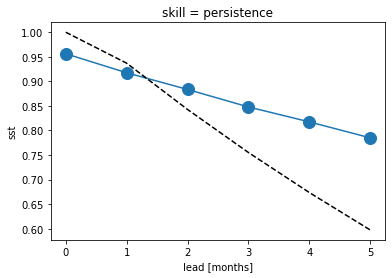

In [189]:
acc.sel(skill='initialized').sst.plot(marker='o', markersize=12)
acc.sel(skill='persistence').sst.plot(color='k', linestyle='--')

### IOD 

In [192]:
IOD_ecmwf = utils.indices.calculate_IOD(dset_ecmwf)

In [193]:
IOD_ersst = utils.indices.calculate_IOD(dset_ersst, dim='time')

In [194]:
hindcast_IOD = HindcastEnsemble(IOD_ecmwf)

In [195]:
hindcast_IOD = hindcast_IOD.add_observations(IOD_ersst)

In [196]:
hindcast_IOD.load()

climpred.HindcastEnsemble

<Initialized Ensemble>
Dimensions: (init: 468, lead: 6, member: 25)
Coordinates:
 * member (member) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
 * lead (lead) int64 0 1 2 3 4 5
 * init (init) object 1981-01-01 00:00:00 ... 2019-12-01 00:00:00
Data variables:
 sst (init, lead, member) float32 -0.022622585 -0.39668542 ... 1.2532713 Initialized Ensemble Dimensions: init : 468 lead : 6 member : 25 Coordinates: (3) member (member) int32 0 1 2 3 4 5 6 ... 19 20 21 22 23 24 long_name : ensemble_member array([ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
 18, 19, 20, 21, 22, 23, 24], dtype=int32) lead (lead) int64 0 1 2 3 4 5 units : months array([0, 1, 2, 3, 4, 5]) init (init) object 1981-01-01 00:00:00 ... 2019-12-... array([cftime.DatetimeProlepticGregorian(1981, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1981, 2, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1981, 3, 1, 0, 0, 0, 0), ...,
 cftime.DatetimeProlepticGregorian(2019, 10, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(2019, 11, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(2019, 12, 1, 0, 0, 0, 0)],
 dtype=object) Data variables: (1) sst (init, lead, member) float32 -0.022622585 ... 1.2532713 array([[[-2.26225853e-02, -3.96685421e-01, -4.66960430e-01, ...,
 -3.19409251e-01, -7.64245987e-01, -3.61703396e-01],
 [ 1.05709982e+00, 2.62327701e-01, 2.16894090e-01, ...,
 -4.39548314e-01, 1.51680946e-01, 3.06289673e-01],
 [ 4.46550339e-01, -1.09375942e+00, -1.20061904e-01, ...,
 -9.55137134e-01, -1.54298782e-01, 5.96728206e-01],
 [-5.70960224e-01, -1.69093654e-01, 3.69375080e-01, ...,
 -4.82587099e-01, 2.88571417e-02, -1.09011054e-01],
 [ 3.82652819e-01, -3.76914680e-01, -9.40853059e-02, ...,
 -1.00664067e+00, -7.29659319e-01, -6.03897095e-01],
 [ 7.30618656e-01, -4.72805470e-01, -3.02284583e-02, ...,
 -2.43071049e-01, -8.22505951e-01, 4.83582228e-01]],

 [[ 2.22527266e-01, 1.42225623e-01, 5.15106320e-01, ...,
 -1.85522407e-01, 7.66127110e-01, -7.05615222e-01],
 [ 1.05537701e+00, 1.08230114e-03, 3.26868117e-01, ...,
 -2.92307019e-01, -2.76853919e-01, -8.15108776e-01],
 [ 1.12507594e+00, 2.05116093e-01, -2.22214639e-01, ...,
 1.79917067e-01, 3.35125446e-01, -1.12044609e+00],
 [-8.10720325e-02, -1.64915204e-01, -7.73895860e-01, ...,
...
 [ 1.25915170e+00, 5.16554594e-01, 1.02535939e+00, ...,
 1.65136647e+00, 1.14067876e+00, 1.44167221e+00],
 [ 7.16444850e-01, 9.14211571e-01, 8.59751523e-01, ...,
 2.03361320e+00, 8.26427519e-01, 7.68302560e-01],
 [ 1.25858843e+00, 9.24782634e-01, 3.15911174e-02, ...,
 1.48269868e+00, 1.02783954e+00, 1.38387287e+00]],

 [[ 2.12338972e+00, 1.91556656e+00, 2.46982670e+00, ...,
 1.71838522e+00, 2.01055574e+00, 1.98665106e+00],
 [ 2.25948000e+00, 1.59803653e+00, 1.78826070e+00, ...,
 1.51550663e+00, 1.55599749e+00, 1.08723211e+00],
 [ 1.27856100e+00, 1.04608893e+00, 7.76940882e-01, ...,
 3.88044357e-01, 1.56852841e+00, 9.12210345e-01],
 [ 1.03861678e+00, -2.21741557e-01, -1.94938302e-01, ...,
 6.11001909e-01, 1.21577871e+00, 1.65211284e+00],
 [ 1.55936182e-01, 2.50259638e-01, -3.14169526e-01, ...,
 5.49577355e-01, 1.39003921e+00, 2.56265998e+00],
 [ 1.75266337e+00, 1.36521268e+00, 9.91868496e-01, ...,
 1.71301758e+00, 1.48305094e+00, 1.25327134e+00]]],
 dtype=float32) Attributes: (0)

<Observations>
Dimensions: (time: 495)
Coordinates:
 * time (time) object 1979-01-01 00:00:00 ... 2020-03-01 00:00:00
 month (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 5 6 7 8 9 10 11 12 1 2 3
Data variables:
 sst (time) float32 0.57511103 -0.42000955 ... -0.5562376 -0.18621182 Observations Dimensions: time : 495 Coordinates: (2) time (time) object 1979-01-01 00:00:00 ... 2020-03-... array([cftime.DatetimeProlepticGregorian(1979, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1979, 2, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1979, 3, 1, 0, 0, 0, 0), ...,
 cftime.DatetimeProlepticGregorian(2020, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(2020, 2, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(2020, 3, 1, 0, 0, 0, 0)], dtype=object) month (time) int64 1 2 3 4 5 6 7 ... 9 10 11 12 1 2 3 array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5,
 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3,
 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8,
 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1,
 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6,
 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4,
 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9,
 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2,
 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7,
 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5,
 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3,
 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8,
 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1,
 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6,
 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4,
 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9,
 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2,
 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7,
 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5,
 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3,
 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8,
 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1,
 2, 3]) Data variables: (1) sst (time) float32 0.57511103 ... -0.18621182 array([ 5.75111032e-01, -4.20009553e-01, -5.25153816e-01, 1.72120422e-01,
 2.46467501e-01, 1.27749372e+00, 1.99188113e-01, -5.14222980e-01,
 -9.74676967e-01, -7.59619594e-01, -1.37168300e+00, -5.30984938e-01,
 6.57975674e-02, 3.46537471e-01, -6.58843100e-01, 6.77759409e-01,
 1.02893186e+00, -1.00852001e+00, -6.38897002e-01, 4.62599456e-01,
 -1.16114759e+00, -7.66411662e-01, -4.40639675e-01, 2.41831779e-01,
 1.87873006e-01, 6.75605059e-01, -2.33646154e-01, 1.15964234e+00,
 3.20313931e-01, -3.56518090e-01, -1.09603202e+00, -1.07507443e+00,
 -1.51935327e+00, -1.00293589e+00, -6.22899055e-01, -5.12907624e-01,
 5.61566949e-02, 5.81646919e-01, 8.69623303e-01, 9.49244857e-01,
 1.24399543e+00, 1.02565873e+00, 1.16330242e+00, 1.38856936e+00,
 7.83527970e-01, 2.72326517e+00, 9.71958995e-01, -3.77463102e-01,
 -8.17380130e-01, -1.44795406e+00, -2.37673116e+00, -2.12184739e+00,
 -4.23718870e-01, 1.05398107e+00, 2.18988085e+00, 1.35019541e+00,
 7.04745948e-01, -5.56004047e-02, 2.18365818e-01, -1.63672030e-01,
 -3.06654811e-01, -3.78622651e-01, -1.98932767e-01, 9.34816658e-01,
 -1.23930192e+00, -1.03430033e+00, -1.34893751e+00, -7.98956513e-01,
 -1.00704682e+00, -6.53536022e-01, -9.94571626e-01, -5.82266748e-01,
 -1.91086054e-01, -5.22456706e-01, -4.62191403e-01, -5.57592869e-01,
 -4.47593927e-02, -1.34376490e+00, 3.09815407e-02, -8.71363878e-02,
...
 -5.85651636e-01, -1.70186758e-02, 2.75006413e-01, -3.80807966e-01,
 -4.33742881e-01, -3.13266009e-01, -1

In [197]:
acc = hindcast_IOD.verify(metric='pearson_r', \
                          comparison='e2o', \
                          dim='init', \
                          alignment='maximize', \
                          reference='persistence')

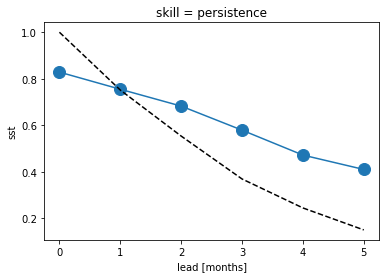

In [198]:
acc.sel(skill='initialized').sst.plot(marker='o', markersize=12)
acc.sel(skill='persistence').sst.plot(color='k', linestyle='--')

In [200]:
result = []
for label, group in IOD_ecmwf.groupby('init.month'):
    hindcast = HindcastEnsemble(group)
    hindcast = hindcast.add_observations(IOD_ersst)
    hindcast.load()
    skill = hindcast.verify(metric='acc', comparison='e2o', dim='init', alignment='maximize')
    result.append(skill)

result = xr.concat(result, dim='month')
result['month'] = np.arange(12) + 1

In [201]:
result = result.to_dataframe()['sst'].unstack()

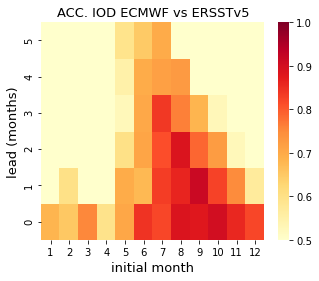

In [202]:
ax = sns.heatmap(result, cmap='YlOrRd', vmin=0.5, vmax=1) 
ax.invert_yaxis()
ax.set_xlabel('initial month', fontsize=13)
ax.set_ylabel('lead (months)', fontsize=13)
ax.set_title("ACC. IOD ECMWF vs ERSSTv5", fontsize=13)
f = plt.gcf() 
f.set_figheight(4)
f.set_figwidth(5)
f.savefig('./ACC_ECMWF_SST_IOD.png', dpi=200, bbox_inches='tight')